In [6]:
# ================================
# AICTE VOIS Internship Project
# Airbnb Hotel Booking Analysis
# Step-by-step EDA answering 9 questions
# ================================

# ---- INITIAL SETUP: run this once at the top of your notebook ----
# ================================
# INITIAL SETUP: Run this first
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import difflib

# Path to your uploaded Airbnb Excel file
FILE_PATH = "/content/1730285881-Airbnb_Open_Data.xlsx"   # adjust if needed
SHEET_NAME = "in"  # sheet name in the Excel file

# Load dataset and normalize column names (lowercase + underscores)
df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# ✅ Create a proper output folder for saving plots & CSVs
OUT_DIR = Path("/content/airbnb_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Helper function: find the best matching column name
def find_col(df, candidates):
    """
    Return the first matching column name from candidates.
    Works with exact names and substrings.
    """
    for cand in candidates:
        if cand in df.columns:
            return cand
    for cand in candidates:
        key = cand.lower().replace(" ", "_")
        for col in df.columns:
            if key in col.replace(" ", "_").lower():
                return col
    return None

# Detect commonly used columns
room_type_col    = find_col(df, ["room_type", "room type", "property_type"])
neigh_group_col  = find_col(df, ["neighbourhood_group", "neighborhood_group"])
neighbourhood_col= find_col(df, ["neighbourhood", "neighborhood"])
price_col        = find_col(df, ["price"])
service_fee_col  = find_col(df, ["service_fee", "service fee", "servicefee"])
construction_col = find_col(df, ["construction_year", "year_built", "built"])
host_id_col      = find_col(df, ["host_id"])
host_name_col    = find_col(df, ["host_name"])
verified_col     = find_col(df, ["host_identity_verified", "host_verified"])
review_col       = find_col(df, ["review_rate_number", "review_scores_rating"])
calc_hosts_col   = find_col(df, ["calculated_host_listings_count"])
availability_col = find_col(df, ["availability_365", "availability"])

# Convert numeric-ish columns
for c in [price_col, service_fee_col, construction_col, review_col, calc_hosts_col, availability_col]:
    if c:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Print summary so you can confirm
print("Dataset shape:", df.shape)
print("Detected columns (key ones):")
print({
    "room_type_col": room_type_col,
    "neigh_group_col": neigh_group_col,
    "neighbourhood_col": neighbourhood_col,
    "price_col": price_col,
    "service_fee_col": service_fee_col,
    "construction_col": construction_col,
    "host_id_col": host_id_col,
    "host_name_col": host_name_col,
    "verified_col": verified_col,
    "review_col": review_col,
    "calc_hosts_col": calc_hosts_col,
    "availability_col": availability_col,
})



Dataset shape: (102599, 26)
Detected columns (key ones):
{'room_type_col': 'room_type', 'neigh_group_col': 'neighbourhood_group', 'neighbourhood_col': 'neighbourhood', 'price_col': 'price', 'service_fee_col': 'service_fee', 'construction_col': 'construction_year', 'host_id_col': 'host_id', 'host_name_col': 'host_name', 'verified_col': 'host_identity_verified', 'review_col': 'review_rate_number', 'calc_hosts_col': 'calculated_host_listings_count', 'availability_col': 'availability_365'}


✅ Unique property types:
['Private room' 'Entire home/apt' 'Shared room' 'Hotel room']

Counts of each property type:
room_type
Entire home/apt    53701
Private room       46556
Shared room         2226
Hotel room           116
Name: count, dtype: int64


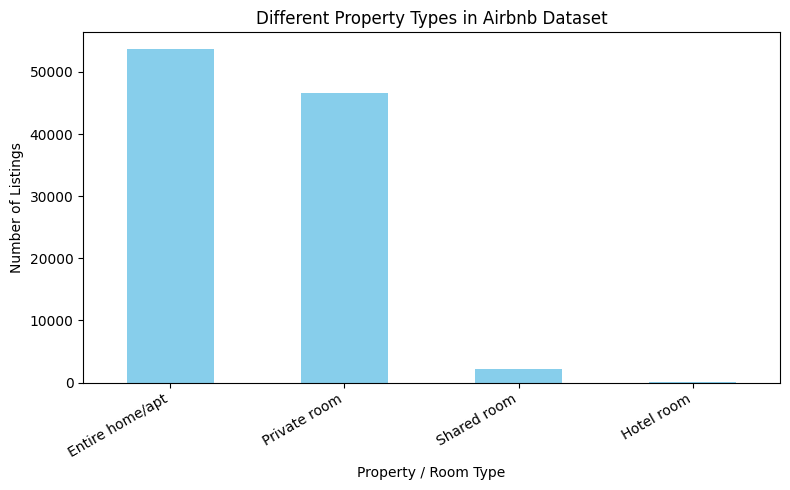

In [7]:
# Q1: Different property / room types
if not room_type_col:
    print("Q1 skipped ❌: property/room type column not found. Run df.columns.tolist() to check.")
else:
    col = room_type_col
    unique_types = df[col].dropna().unique()
    counts = df[col].value_counts(dropna=True)

    print("✅ Unique property types:")
    print(unique_types)
    print("\nCounts of each property type:")
    print(counts)

    # Save results
    counts.to_csv(OUT_DIR / "Q1_property_type_counts.csv")

    # Plot bar chart
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,5))
    counts.plot(kind="bar", color="skyblue")
    plt.title("Different Property Types in Airbnb Dataset")
    plt.xlabel("Property / Room Type")
    plt.ylabel("Number of Listings")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "Q1_property_types.png", dpi=300)
    plt.show()


✅ Raw neighbourhood group counts (top):
neighbourhood_group
Manhattan        43792
Brooklyn         41842
Queens           13267
Bronx             2712
Staten Island      955
MISSING             29
manhatan             1
brookln              1
Name: count, dtype: int64


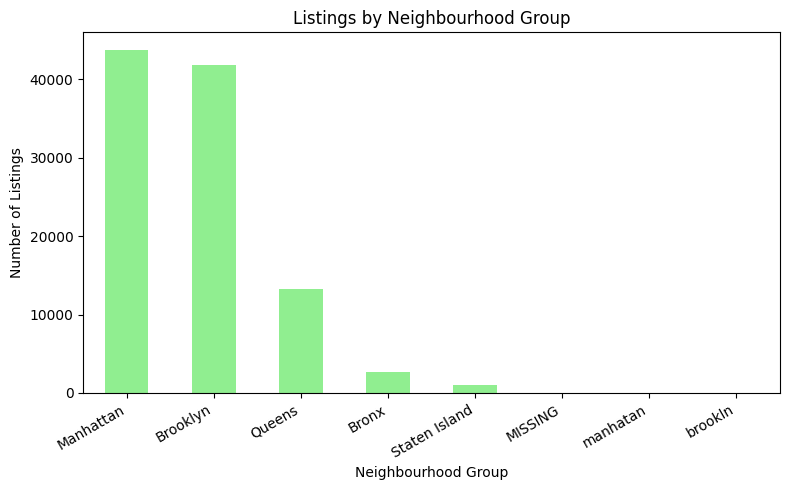

In [8]:
# Q2: Which neighbourhood group has the highest number of listings?
if not neigh_group_col:
    print("Q2 skipped ❌: neighbourhood_group column not found. Run df.columns.tolist() to check.")
else:
    # Raw counts
    raw_counts = df[neigh_group_col].fillna("MISSING").value_counts()
    print("✅ Raw neighbourhood group counts (top):")
    print(raw_counts.head(20))

    # Save results
    raw_counts.to_csv(OUT_DIR / "Q2_neigh_group_counts.csv")

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,5))
    raw_counts.plot(kind="bar", color="lightgreen")
    plt.title("Listings by Neighbourhood Group")
    plt.xlabel("Neighbourhood Group")
    plt.ylabel("Number of Listings")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "Q2_neigh_group.png", dpi=300)
    plt.show()


✅ Average price by neighbourhood group:
neighbourhood_group
Queens           630.21
Bronx            627.77
Brooklyn         626.56
Staten Island    624.49
Manhattan        622.44
brookln          580.00
manhatan         460.00
Name: price, dtype: float64


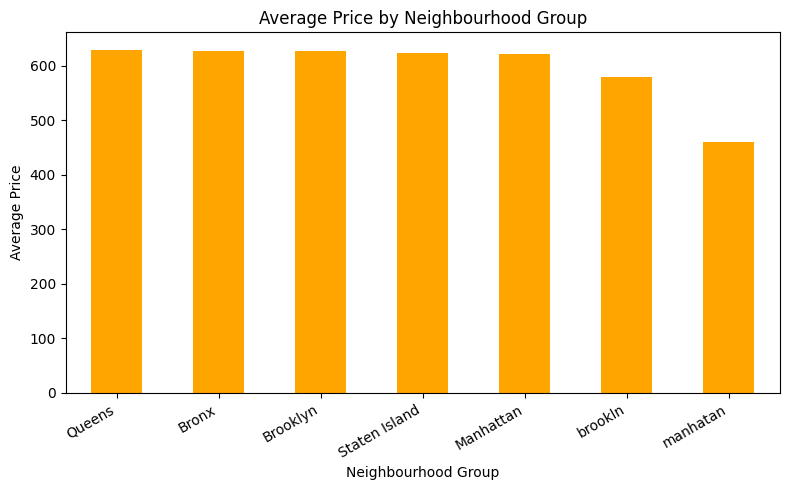

In [9]:
# Q3: Which neighbourhood group has the highest average price?

if not neigh_group_col or not price_col:
    print("Q3 skipped ❌: neighbourhood_group and/or price column not found.")
else:
    avg_price = df.groupby(neigh_group_col)[price_col].mean().sort_values(ascending=False)

    print("✅ Average price by neighbourhood group:")
    print(avg_price.round(2))

    # Save results
    avg_price.round(2).to_csv(OUT_DIR / "Q3_avg_price_by_neigh_group.csv")

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,5))
    avg_price.plot(kind="bar", color="orange")
    plt.title("Average Price by Neighbourhood Group")
    plt.xlabel("Neighbourhood Group")
    plt.ylabel("Average Price")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "Q3_avg_price_by_neigh_group.png", dpi=300)
    plt.show()


Pearson correlation (construction_year vs price): -0.0038


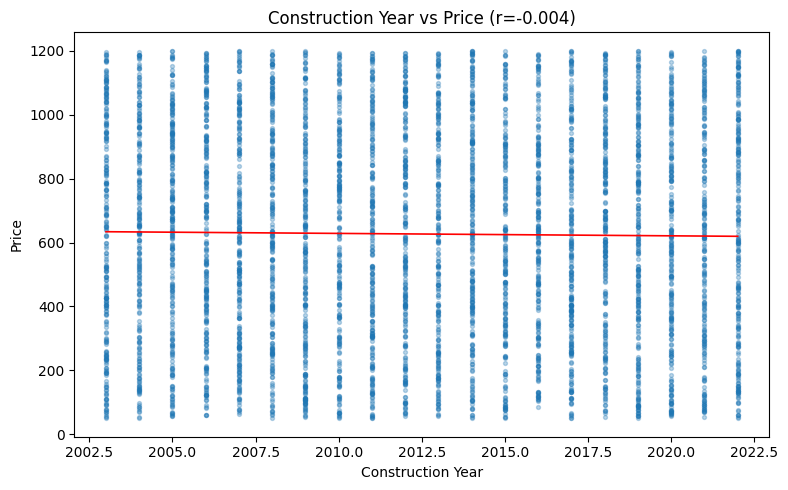

In [10]:
# Q4: Relationship between construction year and price
if not construction_col or not price_col:
    print("Q4 skipped: construction_year and/or price column missing.")
else:
    q4_df = df[[construction_col, price_col]].dropna()
    if q4_df.empty:
        print("Q4: No rows with both construction_year and price.")
    else:
        corr = q4_df[construction_col].corr(q4_df[price_col])
        print(f"Pearson correlation (construction_year vs price): {corr:.4f}")
        sample = q4_df.sample(n=min(5000, len(q4_df)), random_state=42)
        plt.figure(figsize=(8,5))
        plt.scatter(sample[construction_col], sample[price_col], alpha=0.3, s=8)
        plt.xlabel("Construction Year")
        plt.ylabel("Price")
        plt.title(f"Construction Year vs Price (r={corr:.3f})")
        try:
            m, b = np.polyfit(sample[construction_col], sample[price_col], 1)
            xvals = np.array([sample[construction_col].min(), sample[construction_col].max()])
            plt.plot(xvals, m*xvals + b, color="red", linewidth=1.2)
        except Exception:
            pass
        plt.tight_layout()
        plt.savefig(OUT_DIR / "Q4_construction_year_vs_price.png", dpi=300)
        plt.show()


Top 10 hosts (host_id, host_name (if available), host_listings_count):
           host_id  host_listings_count   host_name
7180    6866703084                332.0  Blueground
47037  45153317531                332.0  Blueground
3359    3231719861                332.0  Blueground
75068  72619494405                332.0  Blueground
64399  62221516723                332.0  Blueground
83611  80832323346                332.0  Blueground
86661  83842788941                332.0  Blueground
29226  28199312869                332.0  Blueground
55405  53394556356                332.0  Blueground
86237  83412943157                332.0  Blueground


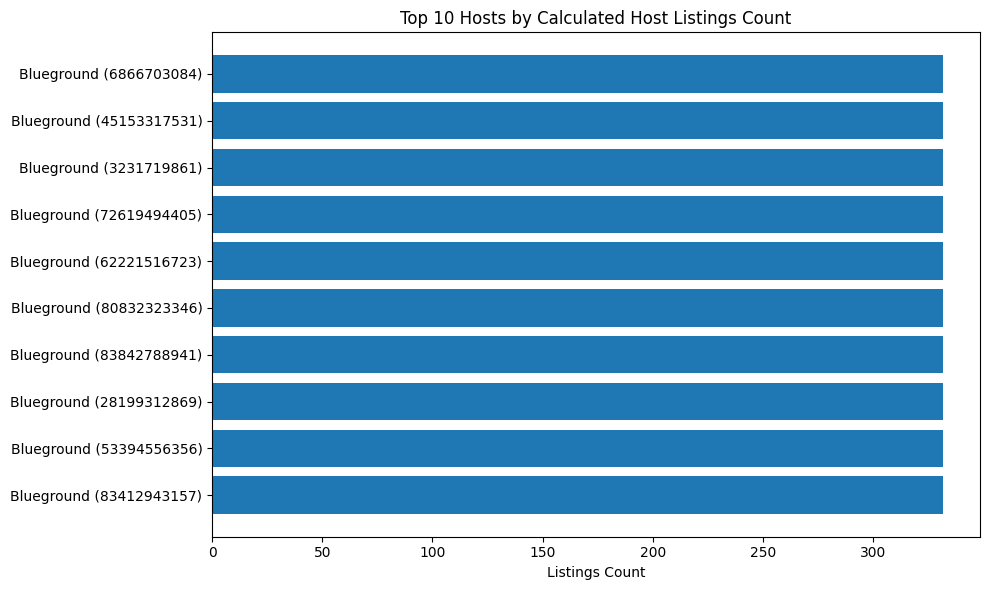

In [11]:
# Q5: Top 10 hosts by calculated host listings count
if not host_id_col or not calc_hosts_col:
    print("Q5 skipped: host_id and/or calculated_host_listings_count missing.")
else:
    # use the maximum calculated_host_listings_count per host (some rows repeat)
    hosts_agg = df.groupby(host_id_col)[calc_hosts_col].max().reset_index().rename(columns={calc_hosts_col: "host_listings_count"})
    # attach host name if available
    if host_name_col:
        host_names = df.groupby(host_id_col)[host_name_col].first().reset_index()
        hosts_agg = hosts_agg.merge(host_names, on=host_id_col, how="left")
    top10 = hosts_agg.sort_values("host_listings_count", ascending=False).head(10)
    print("Top 10 hosts (host_id, host_name (if available), host_listings_count):")
    print(top10)
    top10.to_csv(OUT_DIR / "Q5_top_10_hosts.csv", index=False)
    # plot
    plt.figure(figsize=(10,6))
    if host_name_col and host_name_col in top10.columns:
        labels = top10[host_name_col].fillna("").astype(str) + " (" + top10[host_id_col].astype(str) + ")"
    else:
        labels = top10[host_id_col].astype(str)
    plt.barh(labels[::-1], top10["host_listings_count"].values[::-1])
    plt.title("Top 10 Hosts by Calculated Host Listings Count")
    plt.xlabel("Listings Count")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "Q5_top_10_hosts.png", dpi=300)
    plt.show()


Review score stats by verification status:
               count      mean  median       std
verified_norm                                   
verified       50969  3.286684     3.0  1.284078
unconfirmed    51029  3.271767     3.0  1.284973


/tmp/ipython-input-3690543220.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


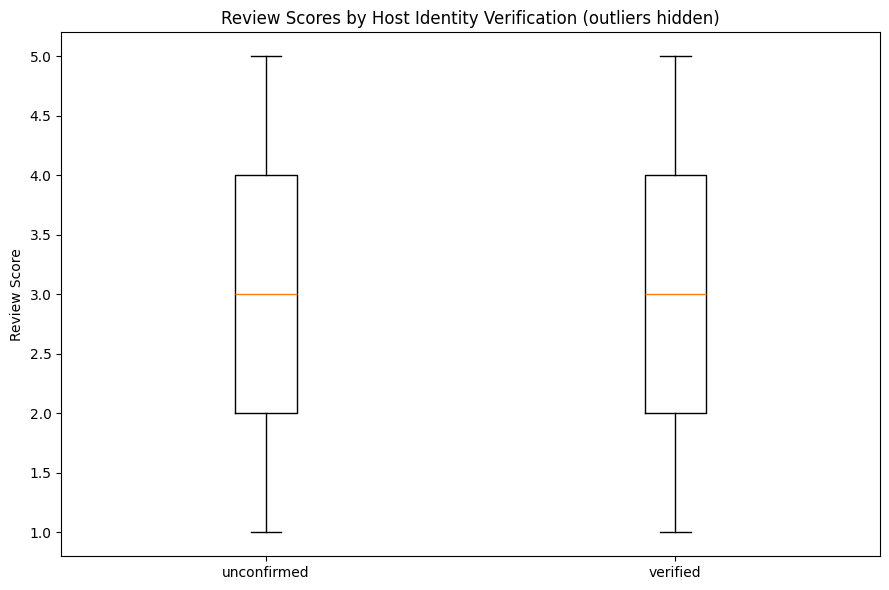

Not enough samples for robust t-test.


In [12]:
# Q6: Verified identity vs review ratings
if not verified_col or not review_col:
    print("Q6 skipped: host_identity_verified and/or review column missing.")
else:
    q6_df = df[[verified_col, review_col]].dropna().copy()
    # Normalize verification markers
    def normalize_verified(x):
        s = str(x).strip().lower()
        if s in {"t", "true", "yes", "y", "1", "verified"}:
            return "verified"
        if s in {"f", "false", "no", "n", "0", "not_verified"}:
            return "not_verified"
        return s
    q6_df["verified_norm"] = q6_df[verified_col].apply(normalize_verified)
    stats = q6_df.groupby("verified_norm")[review_col].agg(["count","mean","median","std"]).sort_values("mean", ascending=False)
    print("Review score stats by verification status:")
    print(stats)
    stats.to_csv(OUT_DIR / "Q6_verified_review_stats.csv")
    # boxplot
    groups = [grp[review_col].values for _, grp in q6_df.groupby("verified_norm")]
    labels = [name for name, _ in q6_df.groupby("verified_norm")]
    plt.figure(figsize=(9,6))
    plt.boxplot(groups, labels=labels, showfliers=False)
    plt.title("Review Scores by Host Identity Verification (outliers hidden)")
    plt.ylabel("Review Score")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "Q6_verified_vs_reviews_boxplot.png", dpi=300)
    plt.show()
    # optional t-test (if scipy available)
    try:
        from scipy.stats import ttest_ind
        verified_vals = q6_df[q6_df["verified_norm"]=="verified"][review_col].dropna()
        not_verified_vals = q6_df[q6_df["verified_norm"]=="not_verified"][review_col].dropna()
        if len(verified_vals)>20 and len(not_verified_vals)>20:
            t_stat, p_val = ttest_ind(verified_vals, not_verified_vals, equal_var=False)
            print(f"T-test (verified vs not_verified): t={t_stat:.3f}, p={p_val:.4e}")
        else:
            print("Not enough samples for robust t-test.")
    except Exception:
        print("scipy not available — t-test skipped.")


Pearson correlation (price vs service_fee): 0.999991


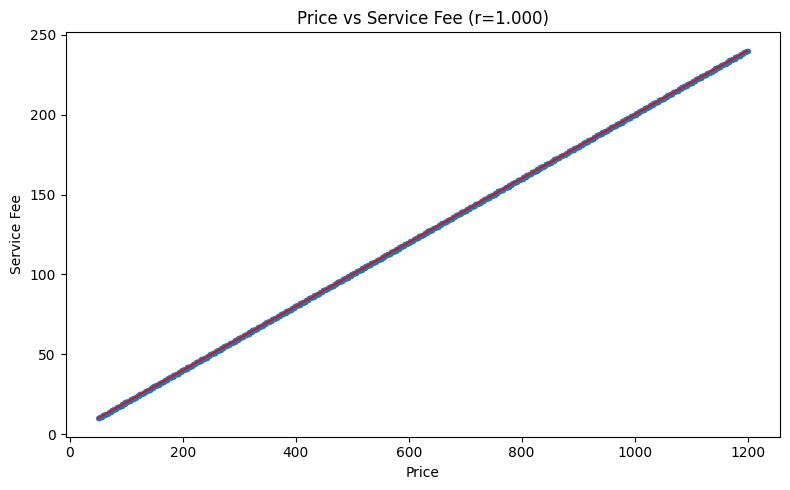

In [13]:
# Q7: Price vs service fee correlation
if not price_col or not service_fee_col:
    print("Q7 skipped: price and/or service_fee column missing.")
else:
    q7_df = df[[price_col, service_fee_col]].dropna()
    if q7_df.empty:
        print("Q7: No rows with both price and service_fee.")
    else:
        corr = q7_df[price_col].corr(q7_df[service_fee_col])
        print(f"Pearson correlation (price vs service_fee): {corr:.6f}")
        sample = q7_df.sample(n=min(5000, len(q7_df)), random_state=42)
        plt.figure(figsize=(8,5))
        plt.scatter(sample[price_col], sample[service_fee_col], alpha=0.3, s=8)
        plt.xlabel("Price")
        plt.ylabel("Service Fee")
        plt.title(f"Price vs Service Fee (r={corr:.3f})")
        try:
            m, b = np.polyfit(sample[price_col], sample[service_fee_col], 1)
            xvals = np.array([sample[price_col].min(), sample[price_col].max()])
            plt.plot(xvals, m*xvals + b, color="red", linewidth=1.2)
        except Exception:
            pass
        plt.tight_layout()
        plt.savefig(OUT_DIR / "Q7_price_vs_service_fee.png", dpi=300)
        plt.show()


Pivot table (avg review score):
room_type            Entire home/apt  Hotel room  Private room  Shared room
neighbourhood_group                                                        
Bronx                           3.35         NaN          3.33         3.26
Brooklyn                        3.25        3.75          3.26         3.34
Manhattan                       3.28        3.50          3.28         3.26
Queens                          3.35        3.75          3.32         3.38
Staten Island                   3.33         NaN          3.48         3.53
brookln                          NaN         NaN          4.00          NaN
manhatan                         NaN         NaN          3.00          NaN


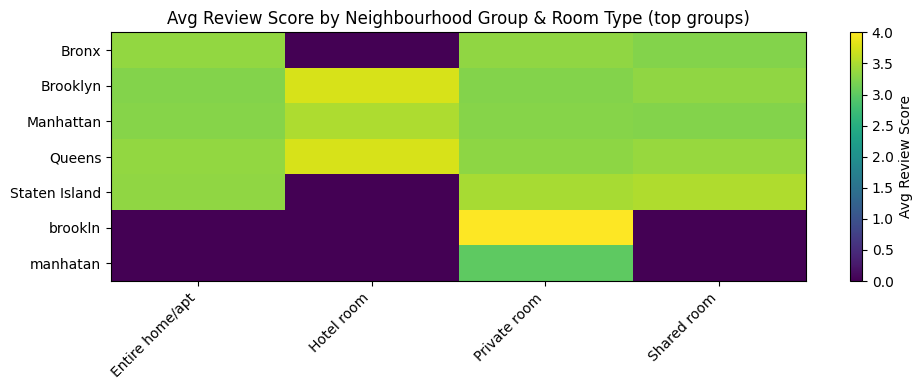

In [14]:
# Q8: Average review score by neighbourhood group and room type
if not review_col or not room_type_col or not neigh_group_col:
    print("Q8 skipped: review, room_type and/or neighbourhood_group column missing.")
else:
    # Use cleaned group if created
    group_col = (neigh_group_col + "_clean") if (neigh_group_col + "_clean") in df.columns else neigh_group_col

    # Optional: limit to top N neighbourhood groups for readability
    top_n = 12
    top_groups = df[group_col].value_counts().head(top_n).index.tolist()
    subset = df[df[group_col].isin(top_groups)]

    pivot = subset.pivot_table(index=group_col, columns=room_type_col, values=review_col, aggfunc="mean").round(2)
    print("Pivot table (avg review score):")
    print(pivot)
    pivot.to_csv(OUT_DIR / "Q8_avg_review_pivot.csv")

    # heatmap-like plot
    plt.figure(figsize=(10, max(4, 0.5*len(pivot.index))))
    mat = pivot.fillna(0).values
    plt.imshow(mat, aspect="auto")
    plt.colorbar(label="Avg Review Score")
    plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45, ha="right")
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.title("Avg Review Score by Neighbourhood Group & Room Type (top groups)")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "Q8_avg_review_heatmap.png", dpi=300)
    plt.show()


Pearson correlation (host listings count vs availability): 0.1592


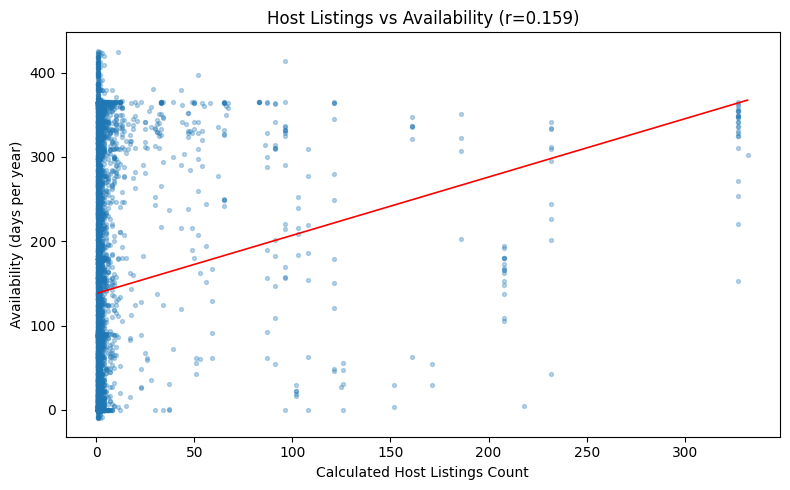


Binned host-listings vs availability (sample):
                   count        mean  median
host_listings_bin                           
(10.0, 50.0]        4134  251.775520   299.0
(50.0, 500.0]       3646  236.447340   277.0
(5.0, 10.0]         4462  226.547512   264.0
(2.0, 5.0]         12073  176.653359   167.0
(1.0, 2.0]         14364  144.620997   112.0
(-0.001, 1.0]      63153  114.697797    62.0


/tmp/ipython-input-1907539675.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = q9_df.groupby("host_listings_bin")[availability_col].agg(["count","mean","median"]).sort_values("mean", ascending=False)


In [15]:
# Q9: Correlation between calculated_host_listings_count and availability_365
if not calc_hosts_col or not availability_col:
    print("Q9 skipped: calculated_host_listings_count and/or availability_365 missing.")
else:
    q9_df = df[[calc_hosts_col, availability_col]].dropna()
    if q9_df.empty:
        print("Q9: No rows to analyze.")
    else:
        corr = q9_df[calc_hosts_col].corr(q9_df[availability_col])
        print(f"Pearson correlation (host listings count vs availability): {corr:.4f}")
        sample = q9_df.sample(n=min(5000, len(q9_df)), random_state=42)
        plt.figure(figsize=(8,5))
        plt.scatter(sample[calc_hosts_col], sample[availability_col], alpha=0.3, s=8)
        plt.xlabel("Calculated Host Listings Count")
        plt.ylabel("Availability (days per year)")
        plt.title(f"Host Listings vs Availability (r={corr:.3f})")
        try:
            m, b = np.polyfit(sample[calc_hosts_col], sample[availability_col], 1)
            xvals = np.array([sample[calc_hosts_col].min(), sample[calc_hosts_col].max()])
            plt.plot(xvals, m*xvals + b, color="red", linewidth=1.2)
        except Exception:
            pass
        plt.tight_layout()
        plt.savefig(OUT_DIR / "Q9_hostlistings_vs_availability.png", dpi=300)
        plt.show()

        # Additional: binned summary to see trend by group
        q9_df["host_listings_bin"] = pd.cut(q9_df[calc_hosts_col], bins=[0,1,2,5,10,50,500], include_lowest=True)
        bin_stats = q9_df.groupby("host_listings_bin")[availability_col].agg(["count","mean","median"]).sort_values("mean", ascending=False)
        print("\nBinned host-listings vs availability (sample):")
        print(bin_stats)
        bin_stats.to_csv(OUT_DIR / "Q9_binned_hostlistings_availability.csv")
